# ASSIGNMENT 3-3b

In [1]:
%matplotlib widget

In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'

import jax
import jax.numpy as jnp
import numpy as np

import haiku as hk
import gymnasium as gym
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from IPython.display import Video 


import warnings
warnings.filterwarnings('ignore')

folder = '3-3b'

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

cwd = os.getcwd()
NUM_ACTION = env.action_space.n
NUM_STATE = env.observation_space.shape

# Generate a random seed
rng = jax.random.PRNGKey(seed=1)
# Use the random seed to generate a sequence of random seeds
rngs = hk.PRNGSequence(rng)
# A new random seed is obtained by calling next(rngs)

bufer_size = 200
batch_size = 128

### Definition of main useful functions

In [4]:
initializer = hk.initializers.VarianceScaling(2.0, "fan_avg", "uniform")

def q_value_layer(s_:jnp.ndarray) -> jnp.ndarray:
    """Value function approximator."""	
    q_value = hk.Sequential([
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(NUM_ACTION, w_init=hk.initializers.RandomUniform(-0.01, 0.01)),
        jnp.ravel
    ])
    return q_value(s_)

def target_q_value_layer(s_:jnp.ndarray) -> jnp.ndarray:
    """Value function approximator."""	
    q_value = hk.Sequential([
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(8, w_init=initializer), jax.nn.relu,
        hk.Linear(NUM_ACTION, w_init=hk.initializers.RandomUniform(-0.01, 0.01)),
        jnp.ravel
    ])
    return q_value(s_)

# define the neural network
nn = hk.without_apply_rng(hk.transform(q_value_layer))
target_nn = hk.without_apply_rng(hk.transform(target_q_value_layer))

# initialize the parameters
params = nn.init(rng, jnp.zeros(NUM_STATE,))
target_params = target_nn.init(rng, jnp.zeros(NUM_STATE,))

# evaluate the neural network
nn_eval = nn.apply
target_nn_eval = target_nn.apply

@jax.jit
def q_value_nn(params_:dict, s_:jnp.ndarray) -> jnp.ndarray:
    """Evaluate the neural network."""
    return nn_eval(params_, s_)

In [5]:
def pi(params_:dict, s_:jnp.ndarray, rng_:np.ndarray) -> jnp.ndarray:
    """Policy function."""
    # q(s,a) for all a in the state s
    q_val = q_value_nn(params_, s_) 
    # indices of the highest q value
    maxval = jnp.where(q_val == jnp.max(q_val))[0]
    # Take random one
    action = jax.random.choice(rng_, maxval)
    
    return action

@jax.jit
def update(params_:dict, grads_, stepsize_:float) -> dict:
    """Update the parameters of the neural network. TD(0) update."""
    return jax.tree_map(lambda p, g: p - stepsize_ * g, params_, grads_)

@jax.jit
def loss_fn(params:dict, target_params:dict, s:jnp.ndarray, a:jnp.ndarray, r:jnp.ndarray, gamma:float, s1:jnp.ndarray) -> jnp.ndarray:
    q_s = q_value_nn(params, s).reshape(-1, NUM_ACTION)
    buffer_size = s.shape[0]
    current_q = q_s[jnp.arange(buffer_size), a]

    q_s1 = target_nn(target_params, s1).reshape(-1, NUM_ACTION)
    q_s1max = jnp.max(q_s1, axis=-1)
    target = r + gamma * q_s1max
    return jnp.mean(jnp.square(target - current_q))

@jax.jit
def update_targets(params:dict, target_params:dict, alpha:float):
    return jax.tree.map(lambda p, tp: (1 - alpha) * tp + alpha * p, params, target_params)

grad_fn = jax.grad(loss_fn)

In [6]:
class ReplayMemory:
    """ Replay memory for storing transitions. """
    
    def __init__(self, size:int, state_shape:tuple):
        """ Initializes the replay memory with a given size and state shape. """
        self.index = 0
        self.is_ready = False  # Tracks when buffer is full
        self.size = size # Size of the buffer
        self.state_buf = jnp.zeros((size, *state_shape), dtype=jnp.float32)
        self.action_buf = jnp.zeros((size,), dtype=jnp.int32)
        self.reward_buf = jnp.zeros((size,), dtype=jnp.float32)
        self.next_state_buf = jnp.zeros((size, *state_shape), dtype=jnp.float32)
        self.done_buf = jnp.zeros((size,), dtype=bool)  # Terminal states
        
    def store(self, s:jnp.ndarray, a:jnp.ndarray, r:jnp.ndarray, s1:jnp.ndarray, done:bool):
        """Stores a new transition in the buffer."""
        idx = self.index  # Current index to store data
        
        # Store the transition
        # Use .at[idx].set() to avoid in-place mutation (jax is immutable)
        self.state_buf = self.state_buf.at[idx].set(s)
        self.action_buf = self.action_buf.at[idx].set(a)
        self.reward_buf = self.reward_buf.at[idx].set(r)
        self.next_state_buf = self.next_state_buf.at[idx].set(s1)
        self.done_buf = self.done_buf.at[idx].set(done)

        # Move to next index, wrap around if buffer is full
        self.index = (self.index + 1) % self.size
        
        if self.index == 0:
            self.is_ready = True

    def batch_sampling(self, batch_size:int, rng):
        """Samples a batch of transitions from the buffer."""
        # If the buffer is not full, sample from the current index
        max_index = self.size if self.is_ready else self.index
         
        # Ensure we have enough samples to sample from
        if batch_size > max_index:
            raise ValueError("Not enough samples in the buffer yet!")

        idx = jax.random.choice(rng, max_index, (batch_size - 1,), replace=False)
        # not correct, it can take the last sample 2 times
        idx = jnp.append(idx, self.index - 1)  # Ensure last added sample is included

        return (self.state_buf[idx], 
                self.action_buf[idx], 
                self.reward_buf[idx], 
                self.next_state_buf[idx], 
                self.done_buf[idx])
    
    def __len__(self):
        return self.size if self.is_ready else self.index
    

In [7]:
s, _ = env.reset()

print("Initial state: ", s)
print("First Q-value for the initial state \n", q_value_nn(params, s))
print("First policy for the initial state \n", pi(params, s, next(rngs)))


Initial state:  [-0.02376921 -0.03675245 -0.00502763 -0.00140718]
First Q-value for the initial state 
 [4.3564363e-05 3.6904079e-05]
First policy for the initial state 
 0


<img src="img/assign-3/DQN-algo.png" alt="alt text" style="width:10cm;"/>

Parameters:

num_ep:int = 2000  
gamma:float = 0.9  
epsilon:float = 0.1  
alpha:float = 0.001  
alpha_T:float = 0.01  
epsilon_decay:float = 0  
alpha_decay:float = 0  
alpha_T_decay:float = 0  
max_trunc_ep:int = 100

In [8]:
env = gym.wrappers.RecordVideo(env=env, video_folder=os.path.join(cwd,"video",folder), name_prefix="training-video", episode_trigger=lambda x: x % 250 == 0)

states = []
actions = []
kl_div = []
losses = []
ep_rewards = []
epsilons = []
next_states = []
td_errors = []
qmatrixes = []

buffer = ReplayMemory(bufer_size, NUM_STATE)

num_ep:int = 3000 #5000
n:int = 0

gamma:float = 0.9 #0.99
epsilon:float = 0.1 #0.05
alpha:float = 0.001
alpha_T:float = 0.01
epsilon_decay:float = 1e-4*0
alpha_decay:float = 1e-3*0
alpha_T_decay:float = 1e-3*0

max_trunc_ep:int = 100

trunc_ep = 0

@jax.jit
def loss_fn(params:dict, target_params:dict, s:jnp.ndarray, a:jnp.ndarray, r:jnp.ndarray, gamma:float, s1:jnp.ndarray) -> jnp.ndarray:
    q_s = q_value_nn(params, s).reshape(-1, NUM_ACTION)
    buffer_size = s.shape[0]
    current_q = q_s[jnp.arange(buffer_size), a]

    q_s1 = q_value_nn(target_params, s1).reshape(-1, NUM_ACTION)
    q_s1max = jnp.max(q_s1, axis=-1)
    target = r + gamma * q_s1max
    return jnp.mean(jnp.square(target - current_q))

grad_fn = jax.grad(loss_fn)


In [9]:
# Simulate
pbar = tqdm(range(num_ep))
for ep in pbar:
    
    # Update the epsilon and alpha
    epsilon_n = epsilon/(1+epsilon_decay*n)
    alpha_n = alpha/(1+alpha_decay*n)
    alpha_T_n = alpha_T/(1+alpha_T_decay*n)

    # Reset Env
    s = env.reset()[0]
    
    rewards = []
    # Run the episode
    for step in range(env.spec.max_episode_steps):

        # e-greedy action
        if jax.random.uniform(next(rngs)) < epsilon_n:
            a = env.action_space.sample()
        else:
            a = pi(params, s, next(rngs))

        # Update Env
        s1, r, terminated, truncated, info = env.step(int(a))
        done = terminated or truncated

        # penalize big theta (normalized to 0.1)
        # r-= ((12 * 2 * (np.pi / 360)) - np.linalg.norm(s1[2])) / (12 * 2 * np.pi / 360)  / 10
        r -= (np.linalg.norm(s1[2]) - np.linalg.norm(s[2])) * 10
        
        if truncated:
            r += 1/(1-gamma)
            trunc_ep += 1
            # print("Truncated episode", trunc_ep)
            
        if terminated:
            r = 0
        
        rewards.append(r)
        buffer.store(s, a, r, s1, done)

        if buffer.is_ready: # start training
            s_batch, a_batch, r_batch, s1_batch, done_batch = buffer.batch_sampling(batch_size, next(rngs))
            
            # append the last sample
            s_batch = jnp.append(s_batch, s[None], axis=0)
            a_batch = jnp.append(a_batch, a)
            r_batch = jnp.append(r_batch, r)
            s1_batch = jnp.append(s1_batch, s1[None], axis=0)
            done_batch = jnp.append(done_batch, done)

            # update using target params
            grads = grad_fn(params, target_params, s_batch, a_batch, r_batch, gamma*(~done_batch), s1_batch)
            params = update(params, grads, alpha)

            # Soft-update target params
            target_params = update_targets(params, target_params, alpha_T_n)
            
        
        env.render()
        
        if terminated or truncated:
            break

        # Update the state before proceeding
        s = s1
    
    n += 1
    epsilons.append(epsilon_n)    
    ep_rewards.append(np.sum(rewards))
    pbar.set_description(f"Reward {np.sum(rewards)}")
    
    if trunc_ep >= max_trunc_ep:
        break

Reward 509.79193115234375:  44%|████▍     | 1331/3000 [32:06<40:15,  1.45s/it]  


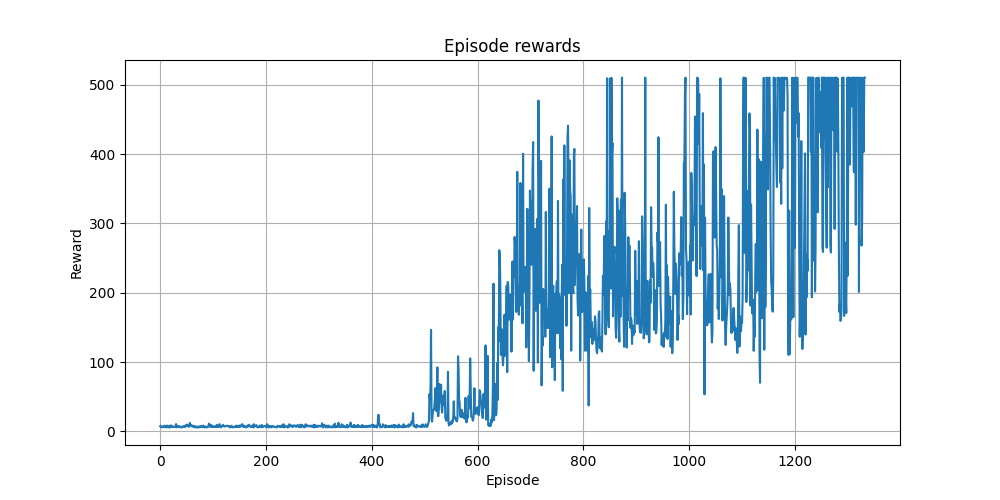

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(ep_rewards)
plt.title("Episode rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.show()

In [20]:
env = gym.wrappers.RecordVideo(env=env, video_folder=os.path.join(cwd,"video",folder), name_prefix="test-video")
s = env.reset()[0]

for step in range(env.spec.max_episode_steps):
        
    a = pi(params, s, next(rngs))

    # Update Env
    s, r, done, truncated, info = env.step(int(a))

    env.render()
    if done:
        break


In [ ]:
print("Final Value Function Parameters:", params)

# jnp.savez(
#     os.path.join(cwd, "saved_models", "3", "model_params_DQN.npz"),
#     value_params=jax.device_get(params)
# )


Final Value Function Parameters: {'linear': {'b': Array([-1.0670471 ,  1.7801605 , -0.5475093 ,  0.7081121 ,  0.03991215,
        0.01236153, -0.03825243,  0.88160336], dtype=float32), 'w': Array([[-0.87402064, -0.2652853 , -0.99104244, -0.42444128,  0.69260436,
        -0.02524259, -0.845362  , -0.48149434],
       [-0.06524764,  0.40015122, -0.19418666,  0.95766324,  0.8386032 ,
         0.022717  ,  0.48523286,  0.9049015 ],
       [-0.36803472, -0.1225068 , -0.1343714 , -0.96406984, -0.33725968,
        -1.2133641 ,  0.02105839,  0.5562799 ],
       [ 0.274712  ,  0.777425  , -0.4666118 ,  0.62091434,  0.7408405 ,
        -0.11501009, -0.15921366,  1.1318488 ]], dtype=float32)}, 'linear_1': {'b': Array([-0.53524536,  0.29188734,  0.07199834,  0.8533826 ,  0.3970029 ,
        0.07218505,  0.02714973,  0.5257967 ], dtype=float32), 'w': Array([[ 0.9417125 , -0.9046057 , -0.60858834, -0.6252163 , -0.45915452,
         0.47982347, -0.64310086, -0.51650405],
       [-0.22943284,  1.02433